# 다중 변수 활용 DL 기반 판매량 예측

## 프로젝트 개요

- 프로젝트명 : 제품 판매량 예측
- 데이터 : Rossmann (Drug store)


- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 이후 3일(t, t+1, t+2) 판매량 예측**
    - 4.1 Fully-connected Neural Network
    - 4.2 1-layer LSTM
    - 4.3 Multi-layer LSTM
    - 4.4 Bi-directional LSTM
    - 4.5 Seq2seq (Auto-regression LSTM)
    
    
- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 다음 날(t) 판매량 예측**
    - 4.6 Dual-stage attention-based RNN(DA-RNN)

## 운영 및 개발 환경

### Library 가져오기

- pandas : 1.1.3
- numpy : 1.19.5
- tensorflow : 2.4.0

In [1]:
import warnings
warnings.filterwarnings("ignore")
from dateutil import relativedelta
import time
import os
import sys
import gc
import datetime
import pandas as pd
import tensorflow as tf
import numpy as np
from importlib import reload
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import seaborn as sns

import prep
import model 
import util

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Directory 생성하기

In [2]:
ROOT_DIR = os.getcwd()

os.chdir(ROOT_DIR)
data_dir = os.path.join(ROOT_DIR, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_processed_dir = os.path.join(data_dir, 'processed')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(data_raw_dir, exist_ok=True)
os.makedirs(data_processed_dir, exist_ok=True)

# 탐색적 데이터 분석

## Dataset 로드

In [3]:
# Load Data file
df = pd.read_csv(os.path.join(data_raw_dir, 'train.csv'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


- **데이터 설명**

    - Id : an Id that represents a (Store, Date) duple within the test set
    - Store : a unique Id for each store
    - Sales : the turnover for any given day (this is what you are predicting)
    - Customers : the number of customers on a given day
    - Open : an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday : indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday : indicates if the (Store, Date) was affected by the closure of public schools
    - Promo : indicates whether a store is running a promo on that day

## Null 값 확인

In [5]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## Target store 선정 및 데이터 정리

In [6]:
df = df.loc[df['Store']==1,:].reset_index()
df = df.drop(['index', 'Store'], axis=1)
df['StateHoliday'] = df['StateHoliday'].astype('str')

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df = df[['Date', 'Sales', 'Customers', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]

In [9]:
df = df.sort_values(by='Date').reset_index(drop=True)

## 각 variable 분포 시각화

<AxesSubplot:xlabel='Sales', ylabel='Count'>

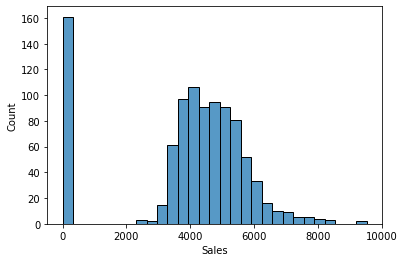

In [10]:
a,b = plt.subplots(1,1, figsize=(6,4))
sns.histplot(df['Sales'])
plt.show()

<AxesSubplot:xlabel='Open', ylabel='Count'>

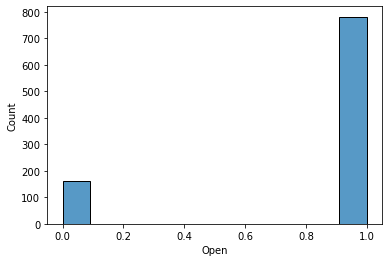

In [11]:
a,b = plt.subplots(1,1, figsize=(6,4))
sns.histplot(df['Open'])
plt.show()

<AxesSubplot:xlabel='Promo', ylabel='Count'>

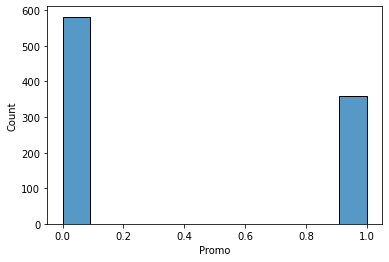

In [12]:
sns.histplot(df['Promo'])
plt.show()

<AxesSubplot:xlabel='StateHoliday', ylabel='Count'>

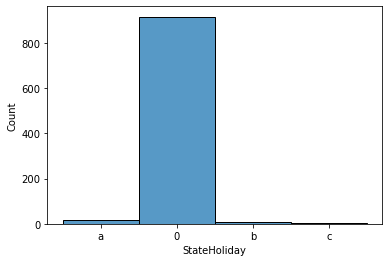

In [13]:
sns.histplot(df['StateHoliday'])
plt.show()

<AxesSubplot:xlabel='SchoolHoliday', ylabel='Count'>

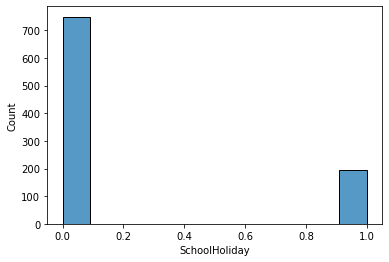

In [14]:
sns.histplot(df['SchoolHoliday'])
plt.show()

## Sales trend 시각화

<AxesSubplot:xlabel='Date', ylabel='Sales'>

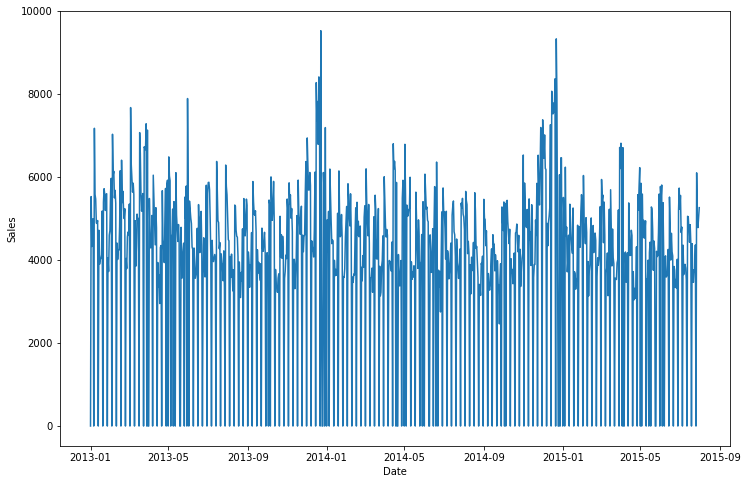

In [15]:
a,b = plt.subplots(1,1, figsize=(12,8))
sns.lineplot(data=df, x='Date', y='Sales')

## 상관성 분석

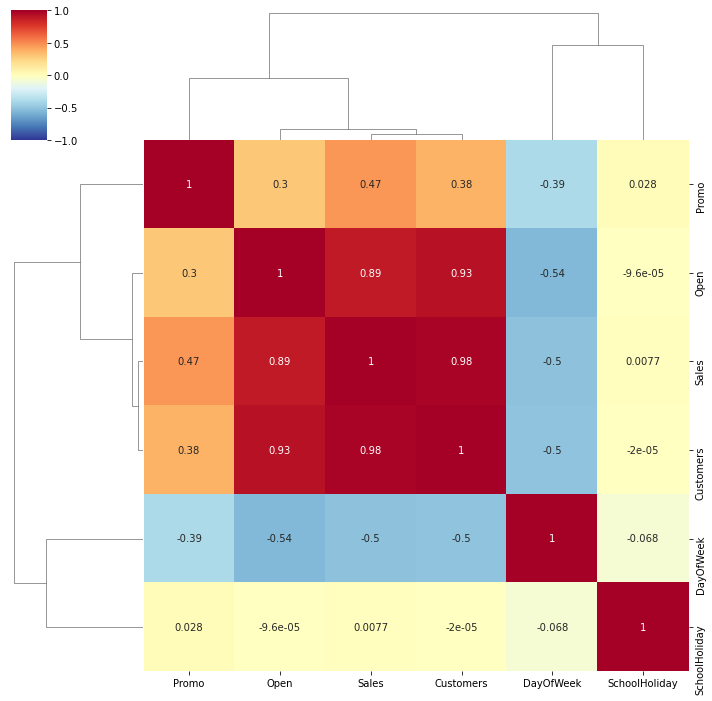

In [16]:
sns.clustermap(df.corr(), 
               annot = True,      
               cmap = 'RdYlBu_r',  
               vmin = -1, vmax = 1,
              )


# 데이터 전처리

## Categorical 변수 변환

In [17]:
df = pd.get_dummies(df, columns = ['DayOfWeek'], dtype='int64')
df = pd.get_dummies(df, columns = ['StateHoliday'], dtype='int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            942 non-null    datetime64[ns]
 1   Sales           942 non-null    int64         
 2   Customers       942 non-null    int64         
 3   Open            942 non-null    int64         
 4   Promo           942 non-null    int64         
 5   SchoolHoliday   942 non-null    int64         
 6   DayOfWeek_1     942 non-null    int64         
 7   DayOfWeek_2     942 non-null    int64         
 8   DayOfWeek_3     942 non-null    int64         
 9   DayOfWeek_4     942 non-null    int64         
 10  DayOfWeek_5     942 non-null    int64         
 11  DayOfWeek_6     942 non-null    int64         
 12  DayOfWeek_7     942 non-null    int64         
 13  StateHoliday_0  942 non-null    int64         
 14  StateHoliday_a  942 non-null    int64         
 15  StateH

## MinMax 정규화

In [19]:
df_y_scaled, scaler_y = prep.minmax_scale_y(df[['Sales']])

In [20]:
df_x_scaled = prep.minmax_scale_x(df[['Customers', 'Open', 'Promo', 'SchoolHoliday',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']])

In [21]:
df = pd.concat([df['Date'], df_y_scaled, df_x_scaled], axis=1)

## Train / Test 나누기

In [22]:
df_train = df[df['Date']<'2015-01-01'].reset_index(drop=True)
df_test = df[df['Date']>='2015-01-01'].reset_index(drop=True)

In [23]:
df_train.shape
df_test.shape

(730, 17)

(212, 17)

## Dataset 변환 (for time-series modeling)

In [24]:
look_back = 30   # x 값으로 볼 time series 길이
look_after = 3  # y 값으로 볼 time series 길이
y_feature = ['Sales']
x_feature = ['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
             'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
             'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
             'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']

X_train, Y_train =  prep.create_dataset(df_train, look_back, look_after, y_feature, x_feature)
X_test, Y_test =  prep.create_dataset(df_test, look_back, look_after, y_feature, x_feature)

X shape : (698, 30, 16)
Y shape : (698, 3, 1)
X shape : (180, 30, 16)
Y shape : (180, 3, 1)


# 모델 훈련 및 평가

- Output : Sales (t, t+1, t+2)
- Input : Sales, Customers, Open, Promo, SchoolHoliday, DayOfWeek_1, DayOfWeek_2, DayOfWeek_3, DayOfWeek_4, DayOfWeek_5, DayOfWeek_6, DayOfWeek_7, StateHoliday_0, StateHoliday_a, StateHoliday_b, StateHoliday_c (t-30, t-29, ..., t-1)


- 평가 : Mean Absolute Error
    - 3일간의 Sales 합 (발주량 예측)

## Fully-connected Neural Network

### 학습

In [25]:
epoch=30
batch_size=30

tm_model, tm_history = model.FCNN(X_train, Y_train, epoch, batch_size, "adam", "mse", X_test, Y_test)

Epoch 1/30
24/24 [==============================] - 1s 17ms/step - loss: 1.0169 - val_loss: 0.3402
Epoch 2/30
24/24 [==============================] - 0s 5ms/step - loss: 0.1648 - val_loss: 0.1639
Epoch 3/30
24/24 [==============================] - 0s 5ms/step - loss: 0.1027 - val_loss: 0.1328
Epoch 4/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0920 - val_loss: 0.0992
Epoch 5/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0831 - val_loss: 0.0906
Epoch 6/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0744 - val_loss: 0.0668
Epoch 7/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0692 - val_loss: 0.0667
Epoch 8/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0683 - val_loss: 0.0690
Epoch 9/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0650 - val_loss: 0.0699
Epoch 10/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0641 - val_loss: 0.0583
Epoch 11/30
24/24 

### 평가

In [26]:
tm_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.0431


0.04308362305164337

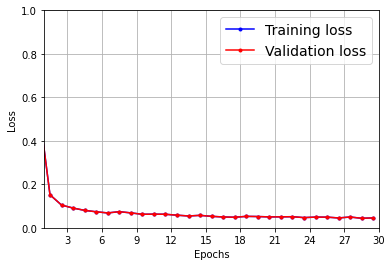

In [27]:
util.plot_learning_curves(tm_history.history["loss"], tm_history.history["val_loss"], epoch)

1351.2446695963542


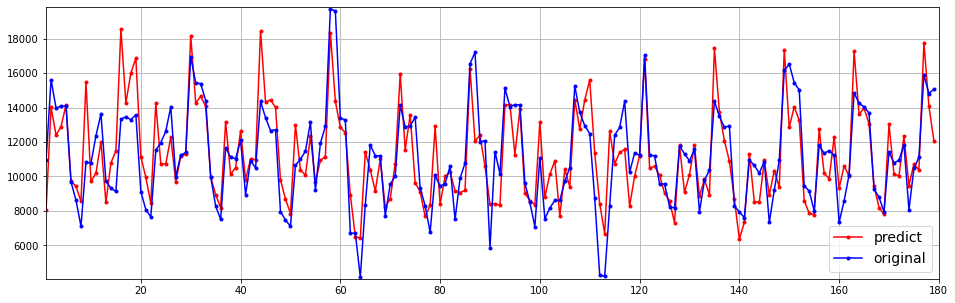

In [28]:
target_size=3
mae = util.GetResult_inverseTransfrom(X_test, Y_test, scaler_y, tm_model, target_size)

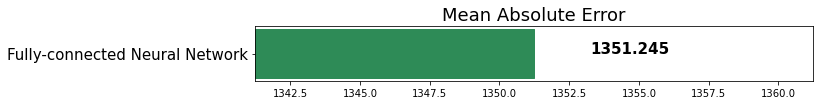

In [29]:
util.Graph_Evaluation(mae, 'Fully-connected Neural Network')

## 1-layer LSTM

### 학습


In [30]:
epochs=20
batch_size=30

tm_model, tm_history = model.LSTM_1_layer(X_train, Y_train, epochs, batch_size, 'mse', X_test, Y_test)

Epoch 1/20
24/24 [==============================] - 2s 74ms/step - loss: 0.2327 - val_loss: 0.0852
Epoch 2/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0824 - val_loss: 0.0521
Epoch 3/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0499 - val_loss: 0.0567
Epoch 4/20
24/24 [==============================] - 2s 68ms/step - loss: 0.0642 - val_loss: 0.0548
Epoch 5/20
24/24 [==============================] - 2s 68ms/step - loss: 0.0494 - val_loss: 0.0442
Epoch 6/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0514 - val_loss: 0.0490
Epoch 7/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0471 - val_loss: 0.0413
Epoch 8/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0394 - val_loss: 0.0425
Epoch 9/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0400 - val_loss: 0.0403
Epoch 10/20
24/24 [==============================] - 2s 69ms/step - loss: 0.0406 - val_loss: 0.0396
Epoch 11/

### 평가

In [31]:
tm_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 13ms/step - loss: 0.0352


0.035227321088314056

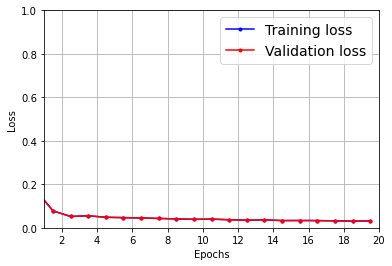

In [32]:
util.plot_learning_curves(tm_history.history["loss"], tm_history.history["val_loss"], epochs)

1070.56044921875


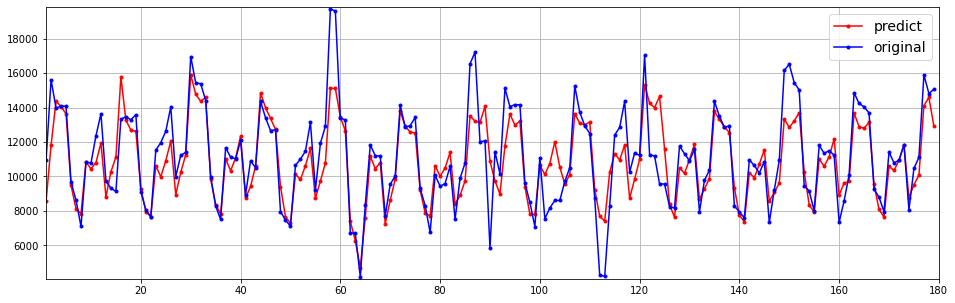

In [33]:
mae = util.GetResult_inverseTransfrom(X_test, Y_test, scaler_y, tm_model, target_size)

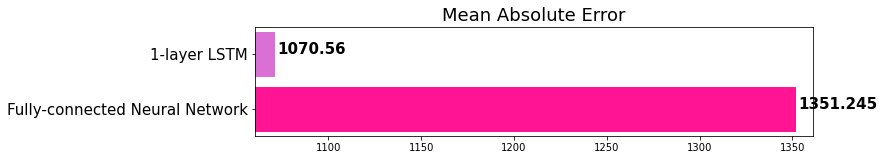

In [34]:
util.Graph_Evaluation(mae, '1-layer LSTM')

## Multi-layer LSTM

### 학습

In [35]:
epochs = 40
batch_size = 30

tm_model, tm_history = model.Multilayer_LSTM(X_train, Y_train, epochs, batch_size, "adam", "mse", X_test, Y_test)

Epoch 1/40
24/24 [==============================] - 7s 219ms/step - loss: 0.2087 - val_loss: 0.1616
Epoch 2/40
24/24 [==============================] - 5s 211ms/step - loss: 0.1740 - val_loss: 0.1560
Epoch 3/40
24/24 [==============================] - 5s 221ms/step - loss: 0.1732 - val_loss: 0.1483
Epoch 4/40
24/24 [==============================] - 5s 213ms/step - loss: 0.1756 - val_loss: 0.1448
Epoch 5/40
24/24 [==============================] - 5s 212ms/step - loss: 0.1815 - val_loss: 0.1486
Epoch 6/40
24/24 [==============================] - 5s 215ms/step - loss: 0.1697 - val_loss: 0.1398
Epoch 7/40
24/24 [==============================] - 5s 211ms/step - loss: 0.1709 - val_loss: 0.1407
Epoch 8/40
24/24 [==============================] - 5s 217ms/step - loss: 0.1589 - val_loss: 0.1366
Epoch 9/40
24/24 [==============================] - 5s 216ms/step - loss: 0.1553 - val_loss: 0.1280
Epoch 10/40
24/24 [==============================] - 5s 211ms/step - loss: 0.1582 - val_loss: 0.1280

### 평가

In [36]:
tm_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 36ms/step - loss: 0.0370


0.0369541235268116

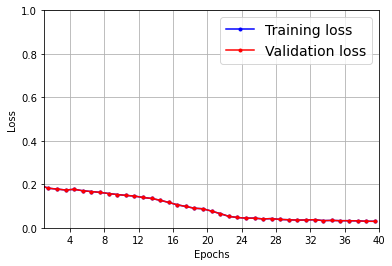

In [37]:
util.plot_learning_curves(tm_history.history["loss"], tm_history.history["val_loss"], epochs)

1049.7414849175348


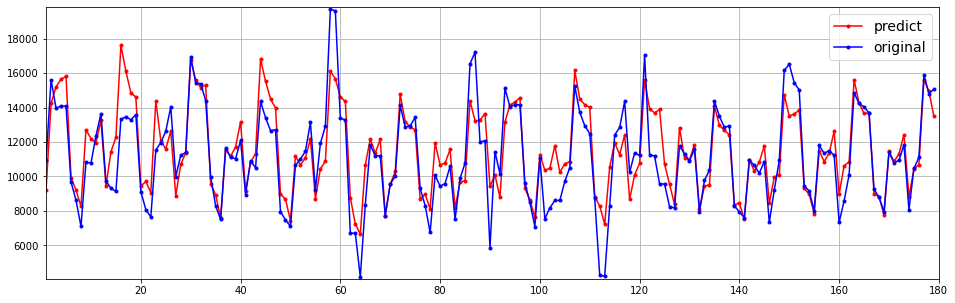

In [38]:
mae = util.GetResult_inverseTransfrom(X_test, Y_test, scaler_y, tm_model, target_size)

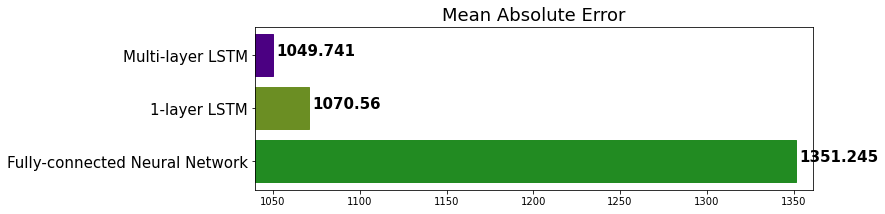

In [39]:
util.Graph_Evaluation(mae, 'Multi-layer LSTM')

## Bi-directional LSTM

### 학습


In [40]:
epochs=40
batch_size=30

tm_model, tm_history = model.BidirectionalLSTM(X_train, Y_train, epochs, batch_size, "adam", "mse", X_test, Y_test)

Epoch 1/40
24/24 [==============================] - 3s 24ms/step - loss: 0.2319 - val_loss: 0.1307
Epoch 2/40
24/24 [==============================] - 0s 8ms/step - loss: 0.1350 - val_loss: 0.0930
Epoch 3/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0981 - val_loss: 0.0677
Epoch 4/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0830 - val_loss: 0.0751
Epoch 5/40
24/24 [==============================] - 0s 14ms/step - loss: 0.0693 - val_loss: 0.0545
Epoch 6/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0620 - val_loss: 0.0468
Epoch 7/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0558 - val_loss: 0.0473
Epoch 8/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 9/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0469 - val_loss: 0.0444
Epoch 10/40
24/24 [==============================] - 0s 7ms/step - loss: 0.0483 - val_loss: 0.0418
Epoch 11/40
24/24

### 평가

In [41]:
tm_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.0387


0.03874100744724274

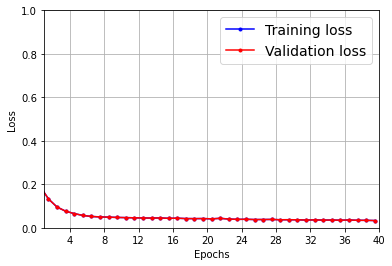

In [42]:
util.plot_learning_curves(tm_history.history["loss"], tm_history.history["val_loss"], epochs)

1067.6634060329861


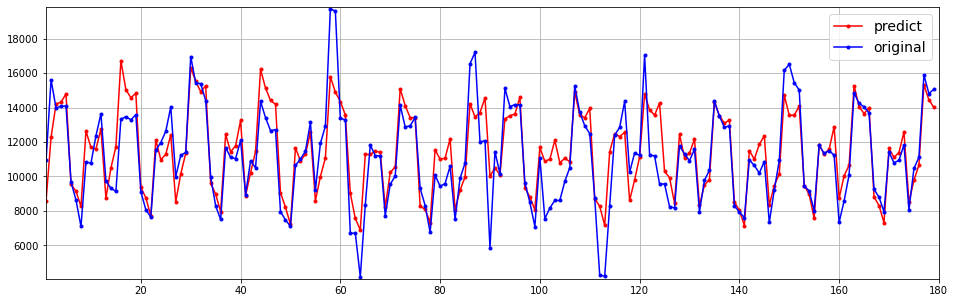

In [43]:
mae = util.GetResult_inverseTransfrom(X_test, Y_test, scaler_y, tm_model, target_size)

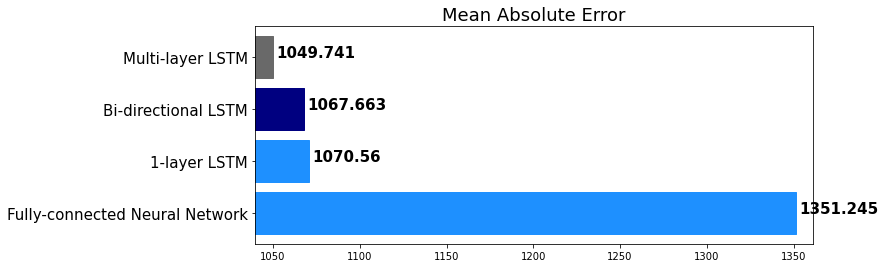

In [44]:
util.Graph_Evaluation(mae, 'Bi-directional LSTM')

## Seq2seq (for real value data, Auto-regression LSTM)

(Example) time_size = 24, target_size = 24
<center><img src='pic/Auto-regression LSTM.png' width='500'></center>  

### 학습

In [45]:
AutoRegression_model = model.AutoRegressionLSTM(units=32, out_steps=3)

In [46]:
epochs=50
AutoRegression_model.compile(loss="mse", optimizer="adam")
history = AutoRegression_model.fit(X_train, Y_train, epochs=epochs, batch_size=30, validation_data=(X_test, Y_test))
                    # validation_data=(x_testFinal, y_testFinal))

Epoch 1/50
24/24 [==============================] - 3s 90ms/step - loss: 0.2239 - val_loss: 0.1428
Epoch 2/50
24/24 [==============================] - 2s 74ms/step - loss: 0.1588 - val_loss: 0.1297
Epoch 3/50
24/24 [==============================] - 2s 75ms/step - loss: 0.1381 - val_loss: 0.1128
Epoch 4/50
24/24 [==============================] - 2s 75ms/step - loss: 0.1314 - val_loss: 0.1003
Epoch 5/50
24/24 [==============================] - 2s 80ms/step - loss: 0.1224 - val_loss: 0.0883
Epoch 6/50
24/24 [==============================] - 2s 77ms/step - loss: 0.1059 - val_loss: 0.0829
Epoch 7/50
24/24 [==============================] - 2s 76ms/step - loss: 0.0966 - val_loss: 0.0746
Epoch 8/50
24/24 [==============================] - 2s 74ms/step - loss: 0.0761 - val_loss: 0.0616
Epoch 9/50
24/24 [==============================] - 2s 74ms/step - loss: 0.0619 - val_loss: 0.0485
Epoch 10/50
24/24 [==============================] - 2s 75ms/step - loss: 0.0523 - val_loss: 0.0478
Epoch 11/

### 평가

In [47]:
AutoRegression_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 15ms/step - loss: 0.0380


0.037977784872055054

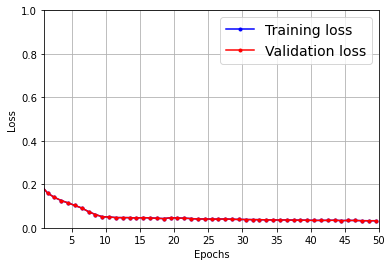

In [48]:
util.plot_learning_curves(history.history["loss"], history.history["val_loss"], epochs)

1122.3313557942708


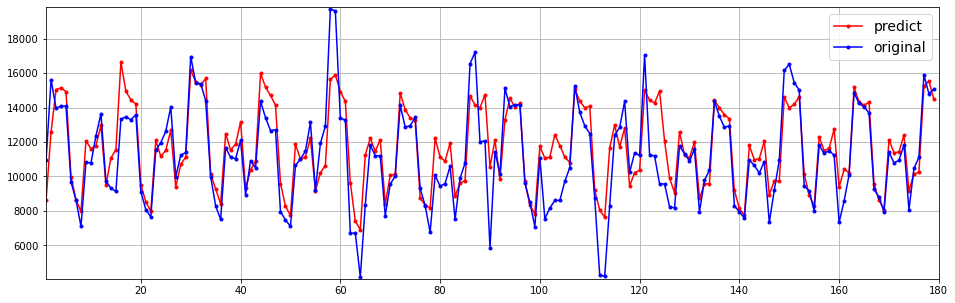

In [49]:
mae = util.GetResult_inverseTransfrom(X_test, Y_test, scaler_y, AutoRegression_model, target_size)

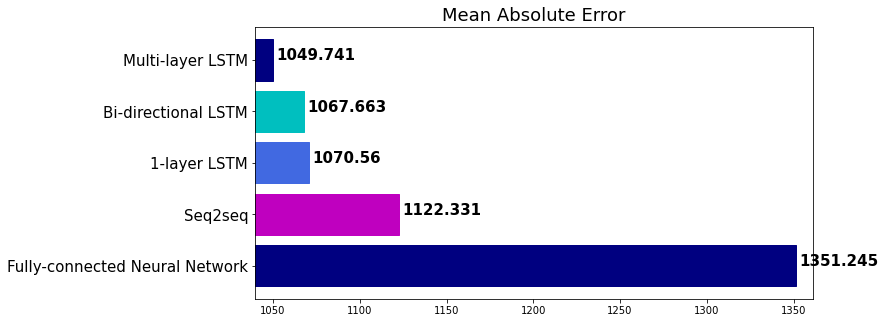

In [50]:
util.Graph_Evaluation(mae, 'Seq2seq')

## Dual-stage attention-based RNN (DA-RNN)

- A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction (2017, Qin, Yao, et al)
    - 342 citations

**Graphical illustration of DARNN**
<center><img src='pic/DARNN.png' width='1000'></center>  

### 학습

In [51]:
interval = 30
m = 32       # encoder lstm unit length
p = 32       # decoder lstm unit length
n = 15        # number of features 
batch_size = 16
learning_rate = 0.001
epochs = 40

darnn = model.model_DARNN(df_train.drop(['Date'], axis=1), df_test.drop(['Date'], axis=1), interval, m, p, n, batch_size, learning_rate, epochs)

Shape of encoder input : (699, 30, 15)
Shape of decoder input : (699, 29, 1)
Shape of target input : (699,)
---------------------------------------
Shape of encoder input : (181, 30, 15)
Shape of decoder input : (181, 29, 1)
Shape of target input : (181,)


In [52]:
preds, labels, history_loss = darnn.createModel()

Epoch 1, Loss: 0.19200405478477478
Epoch 2, Loss: 0.18892647325992584
Epoch 3, Loss: 0.18668104708194733
Epoch 4, Loss: 0.18569502234458923
Epoch 5, Loss: 0.18494655191898346
Epoch 6, Loss: 0.185684934258461
Epoch 7, Loss: 0.1851484775543213
Epoch 8, Loss: 0.1801399141550064
Epoch 9, Loss: 0.17883409559726715
Epoch 10, Loss: 0.17770381271839142
Epoch 11, Loss: 0.1774088442325592
Epoch 12, Loss: 0.1759115606546402
Epoch 13, Loss: 0.17214323580265045
Epoch 14, Loss: 0.17049367725849152
Epoch 15, Loss: 0.16494008898735046
Epoch 16, Loss: 0.16082338988780975
Epoch 17, Loss: 0.15688937902450562
Epoch 18, Loss: 0.1553926020860672
Epoch 19, Loss: 0.13813386857509613
Epoch 20, Loss: 0.13277532160282135
Epoch 21, Loss: 0.1318918913602829
Epoch 22, Loss: 0.10442953556776047
Epoch 23, Loss: 0.08529435843229294
Epoch 24, Loss: 0.08654561638832092
Epoch 25, Loss: 0.07281117886304855
Epoch 26, Loss: 0.0714186429977417
Epoch 27, Loss: 0.06314034759998322
Epoch 28, Loss: 0.05361570417881012
Epoch 29, 

### 평가

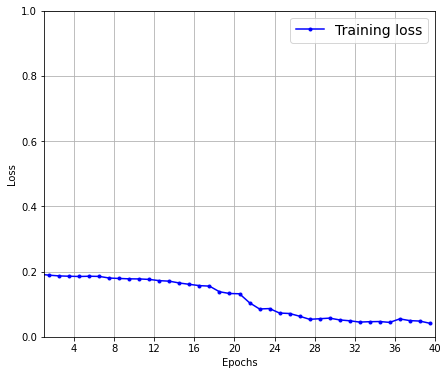

In [53]:
util.plot_learning_curves_train(history_loss, epochs)

719.170372230572


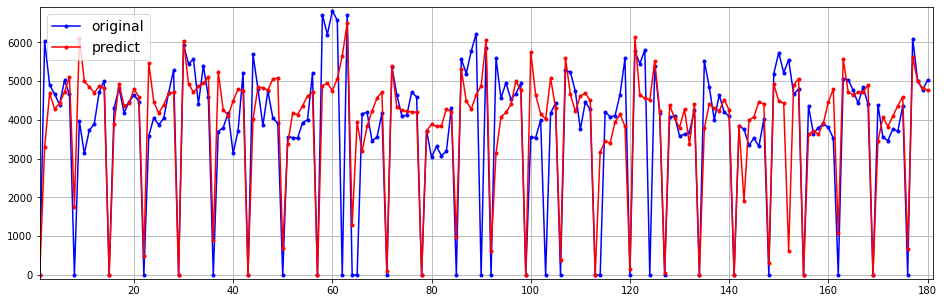

In [54]:
util.GetResult_inverseTransfrom_darnn(preds, labels, scaler_y)

### Attention weight 시각화

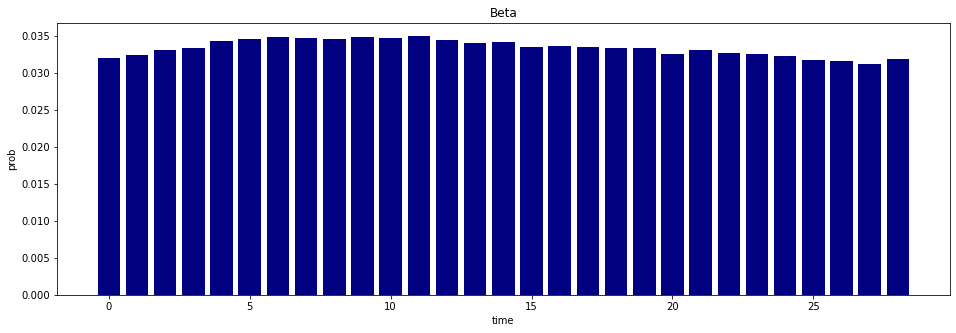

In [55]:
# Mean(coefficient) of temporal attention
darnn.coeff_TemporalAttention()

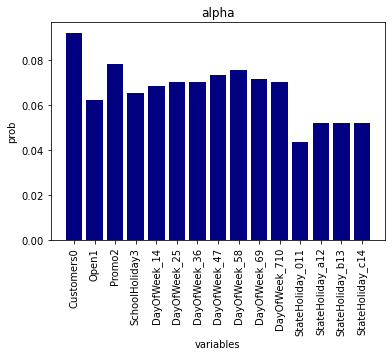

In [56]:
# Mean(coefficient) of Input Attention
variable_dict = {
            "Customers": ["0"],
            "Open": ["1"],
            "Promo": ["2"],
            "SchoolHoliday": ["3"],
            "DayOfWeek_1": ["4"],
            "DayOfWeek_2": ["5"],
            "DayOfWeek_3": ["6"],
            "DayOfWeek_4": ["7"],
            "DayOfWeek_5": ["8"],
            "DayOfWeek_6": ["9"],
            "DayOfWeek_7": ["10"],
            "StateHoliday_0": ["11"],
            "StateHoliday_a": ["12"],
            "StateHoliday_b": ["13"],
            "StateHoliday_c": ["14"]    
        }

darnn.coeff_InputAttention(variable_dict)

# 결과 리뷰 및 점검

- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 이후 3일(t, t+1, t+2) 판매량 예측**
- 평가 : Mean Absolute Error
    - 3일간의 Sales 합 (발주량 예측)

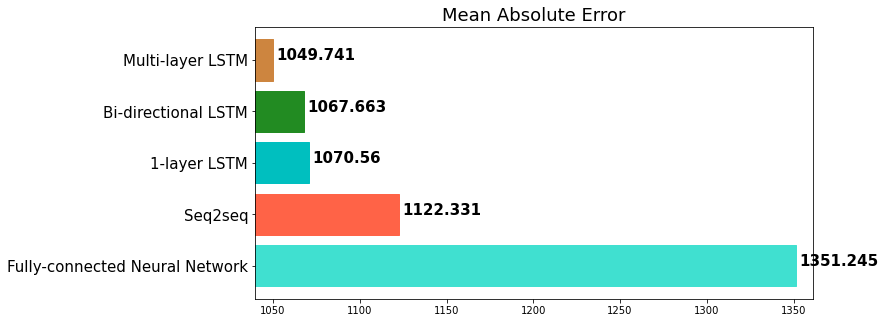

In [57]:
util.Graph_Evaluation(mae, 'Seq2seq')

- **과거 30일(t-30, t-29, ..., t-1) 판매량 관련 데이터를 이용하여, 다음 날(t) 판매량 예측**

719.170372230572


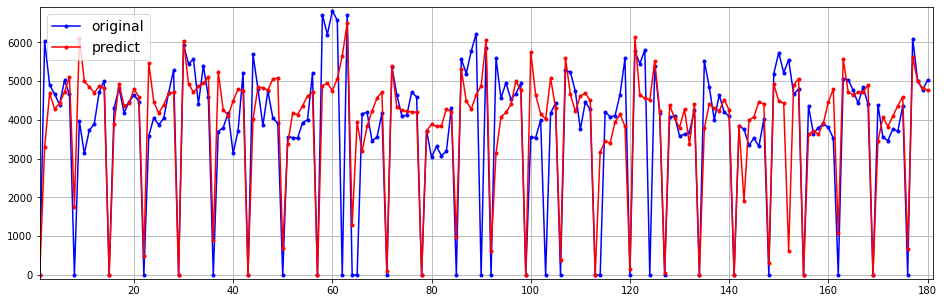

In [58]:
util.GetResult_inverseTransfrom_darnn(preds, labels, scaler_y)